# Kaggle - Titanic Machine Learning from Disaster

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
%matplotlib inline

### Data Cleaning and Analysis

In [84]:
data = pd.read_csv('train.csv')

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


There are missing values in columns Age, Cabin and Embarked. Let's look at the distributions of the data

In [86]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In order to train some machine learning algorithm, we need to replace the alphabets in the Embarked column by numbers. We'll replace S, C, and Q by 0, 1, and 2. Similarly, we replace male and female in the Sex column by 1 and 0 repectively. We also drop the Cabin column as we don't use it for training our ML algorithm.

In [87]:
data.replace({'Cabin' : { None : 'Unknown' }}, inplace=True)
data['Cabin_modified']=[i[0].upper() for i in list(data['Cabin'])]
sex = {'male':1,'female':0}
embarked = {'S':0,'C':1,'Q':2}
cabin_class = {'U':0, 'C':1, 'E':2, 'G':3, 'D':4, 'A':5, 'B':6, 'F':7, 'T':8}
data['sex_type'] = data['Sex'].map(sex)
data['embarked_numeric'] = data['Embarked'].map(embarked)
data['Cabin_Class'] = data['Cabin_modified'].map(cabin_class)

There are 2 missing values in the column Embarked and multiple missing values (~700) in the Age column. Let us try to estimate these missing values

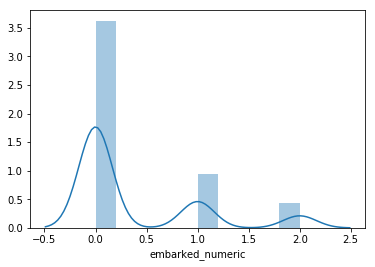

In [88]:
sb.distplot(data['embarked_numeric'].dropna())

Looking at the above distribution, it is clear that most passengers belonged to the class 0. Let us assume that the embarked_numeric value of the missing data is 0

In [89]:
data[data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_modified,sex_type,embarked_numeric,Cabin_Class
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B,0,NaN,6
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B,0,NaN,6


In [90]:
data.replace({'embarked_numeric' : { None : 0 }}, inplace=True)
data.drop('Embarked',1,inplace=True)

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId         891 non-null int64
Survived            891 non-null int64
Pclass              891 non-null int64
Name                891 non-null object
Sex                 891 non-null object
Age                 714 non-null float64
SibSp               891 non-null int64
Parch               891 non-null int64
Ticket              891 non-null object
Fare                891 non-null float64
Cabin               891 non-null object
Cabin_modified      891 non-null object
sex_type            891 non-null int64
embarked_numeric    891 non-null float64
Cabin_Class         891 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 104.5+ KB


In [92]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,sex_type,embarked_numeric,Cabin_Class
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,0.361392,0.811448
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,0.635673,1.815143
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,1.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,2.000000,8.000000


The age distributions on the basis of sex and embarked numeric value is shown below. We can use this distribution to estimate the values of the missing data

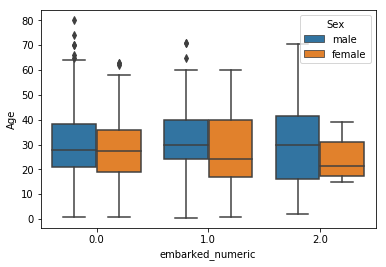

In [93]:
d = data.dropna()
sb.boxplot(x=d.embarked_numeric,y=d.Age,hue=d.Sex)

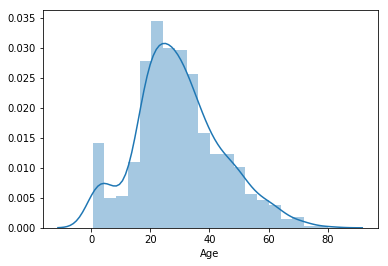

In [94]:
sb.distplot(d.Age)

In [95]:
data['Age'] = data['Age'].groupby([data['sex_type'], data['Pclass'],data['embarked_numeric']]).apply(lambda x: x.fillna(x.median()))

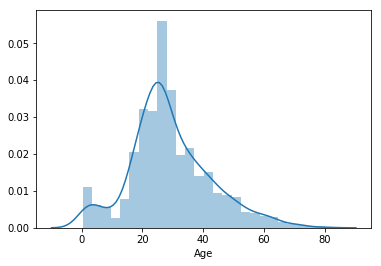

In [96]:
sb.distplot(data.Age)

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId         891 non-null int64
Survived            891 non-null int64
Pclass              891 non-null int64
Name                891 non-null object
Sex                 891 non-null object
Age                 891 non-null float64
SibSp               891 non-null int64
Parch               891 non-null int64
Ticket              891 non-null object
Fare                891 non-null float64
Cabin               891 non-null object
Cabin_modified      891 non-null object
sex_type            891 non-null int64
embarked_numeric    891 non-null float64
Cabin_Class         891 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 104.5+ KB


### Data Loading for ML

In [ ]:
y = data[['Survived']]

In [ ]:
X = data[['Pclass','sex_type','embarked_numeric','Parch','SibSp','Age','Fare','Cabin_Class']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Decision Tree Classifier

parameters = {'criterion':['gini','entropy'],'splitter':['best','random']}
abc = DecisionTreeClassifier()
clf = GridSearchCV(abc,parameters)
clf.fit(X_train,y_train.values.ravel())
print(clf.best_estimator_)
print(clf.best_score_)

clf.score(X_test,y_test)

In [ ]:
DecisionTree = DecisionTreeClassifier(criterion='entropy',splitter='best')
scores = cross_val_score(DecisionTree, X, y.values.ravel(), cv=5)
print(scores)
print('Mean Accuracy: %f'%(np.mean(scores)))

### Random Forests

In [ ]:
parameters = {'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False]}
abc = RandomForestClassifier()
clf = GridSearchCV(abc,parameters)
clf.fit(X,y.values.ravel())
print(clf.best_estimator_)
print(clf.best_score_)

In [ ]:
RandomForest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
scores = cross_val_score(RandomForest, X, y.values.ravel(), cv=10)
print(scores)
print('Mean Accuracy: %f'%(np.mean(scores)))

In [ ]:
RandomForest.fit(X, y.values.ravel())

### Support Vector Machines

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train.ravel)

In [ ]:
SupportVector = SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
                    decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
                    max_iter=-1, probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False)
scores = cross_val_score(SupportVector, X, y.values.ravel(), cv=10)
print(scores)
print('Mean Accuracy: %f'%(np.mean(scores)))

In [ ]:
SupportVector.fit(X, y.values.ravel())

### Deep Learning

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_shape=(6,)))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["accuracy"])
    return model

In [ ]:
model = KerasClassifier(build_fn=create_model,epochs=100,batch_size=64, verbose=0)
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_results = grid.fit(np.array(X_train),np.array(y_train))

In [ ]:
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))

In [ ]:
model = KerasClassifier(build_fn=create_model,epochs=100,batch_size=64, verbose=0)
model.fit(np.array(X_train),np.array(y_train))
model.score(np.array(X_test),np.array(y_test))

In [ ]:
model = KerasClassifier(build_fn=create_model,epochs=100,batch_size=64, verbose=0)
scores = cross_val_score(model,np.array(X),np.array(y), cv=10)
print(scores)
print('Mean Accuracy: %f'%(np.mean(scores)))

In [ ]:
model = KerasClassifier(build_fn=create_model,epochs=100,batch_size=64, verbose=0)
model.fit(np.array(X),np.array(y))

### Train Dataset

In [99]:
data = pd.read_csv('train.csv')
data.replace({'Cabin' : { None : 'Unknown' }}, inplace=True)
data['Cabin_modified']=[i[0].upper() for i in list(data['Cabin'])]
sex = {'male':1,'female':0}
embarked = {'S':0,'C':1,'Q':2}
cabin_class = {'U':0, 'C':1, 'E':2, 'G':3, 'D':4, 'A':5, 'B':6, 'F':7, 'T':8}
data['sex_type'] = data['Sex'].map(sex)
data['embarked_numeric'] = data['Embarked'].map(embarked)
data['Cabin_Class'] = data['Cabin_modified'].map(cabin_class)
data.replace({'embarked_numeric' : { None : 0 }}, inplace=True)
data.drop('Embarked',1,inplace=True)
data['Age'] = data['Age'].groupby([data['sex_type'], data['Pclass'],data['embarked_numeric']]).apply(lambda x: x.fillna(x.median()))
data[data['Fare'].isnull()]
data['Fare'] = data['Fare'].groupby([data['sex_type'], data['Pclass'],data['embarked_numeric']]).apply(lambda x: x.fillna(x.median()))
data['Cabin_Class_U'] = data['Cabin_Class'].map({0:1})
data.replace({'Cabin_Class_U' : { None : 0 }}, inplace=True)
data['Cabin_Class_C'] = data['Cabin_Class'].map({1:1})
data.replace({'Cabin_Class_C' : { None : 0 }}, inplace=True)
data['Cabin_Class_E'] = data['Cabin_Class'].map({2:1})
data.replace({'Cabin_Class_E' : { None : 0 }}, inplace=True)
data['Cabin_Class_G'] = data['Cabin_Class'].map({3:1})
data.replace({'Cabin_Class_G' : { None : 0 }}, inplace=True)
data['Cabin_Class_D'] = data['Cabin_Class'].map({4:1})
data.replace({'Cabin_Class_D' : { None : 0 }}, inplace=True)
data['Cabin_Class_A'] = data['Cabin_Class'].map({5:1})
data.replace({'Cabin_Class_A' : { None : 0 }}, inplace=True)
data['Cabin_Class_B'] = data['Cabin_Class'].map({6:1})
data.replace({'Cabin_Class_B' : { None : 0 }}, inplace=True)
data['Cabin_Class_F'] = data['Cabin_Class'].map({7:1})
data.replace({'Cabin_Class_F' : { None : 0 }}, inplace=True)
data['Cabin_Class_T'] = data['Cabin_Class'].map({8:1})
data.replace({'Cabin_Class_T' : { None : 0 }}, inplace=True)
data['Embarked_S'] = data['embarked_numeric'].map({0:1})
data.replace({'Embarked_S' : { None : 0 }}, inplace=True)
data['Embarked_C'] = data['embarked_numeric'].map({1:1})
data.replace({'Embarked_C' : { None : 0 }}, inplace=True)
data['Embarked_Q'] = data['embarked_numeric'].map({2:1})
data.replace({'Embarked_Q' : { None : 0 }}, inplace=True)
data['Pclass1'] = data['Pclass'].map({1:1})
data.replace({'Pclass1' : { None : 0 }}, inplace=True)
data['Pclass2'] = data['Pclass'].map({2:1})
data.replace({'Pclass2' : { None : 0 }}, inplace=True)
data['Pclass3'] = data['Pclass'].map({3:1})
data.replace({'Pclass3' : { None : 0 }}, inplace=True)
data['Title'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"
                        }    
data['Title'] = data.Title.map(Title_Dictionary)
titles_dummies = pd.get_dummies(data['Title'],prefix='Title')
data = pd.concat([data,titles_dummies],axis=1)

In [100]:
X = data[['sex_type','Title_Mr','Fare','Title_Miss','Title_Mrs','Pclass3','Age','SibSp','Pclass1','Parch','Pclass2']]
y = data['Survived']

In [105]:
RandomForest = RandomForestClassifier()
scores = cross_val_score(RandomForest, X, y.values.ravel(), cv=10)
print(scores)
print('Mean Accuracy: %f'%(np.mean(scores)))

[ 0.73333333  0.81111111  0.74157303  0.85393258  0.85393258  0.84269663
  0.82022472  0.75280899  0.82022472  0.86363636]
Mean Accuracy: 0.809347


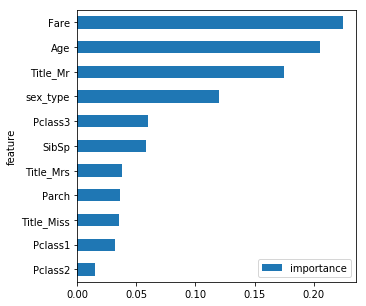

In [104]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = list(RandomForest.feature_importances_)
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(5, 5))

In [106]:
parameters = {'max_depth' : [4, 6, 8, 12],
                 'n_estimators': [100,50],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False]}
abc = RandomForestClassifier()
clf = GridSearchCV(abc,parameters)
clf.fit(X,y.values.ravel())
print(clf.best_estimator_)
print(clf.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.841750841751


In [107]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape  

(891, 4)

In [109]:
clf.fit(X_new,y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [114]:
s=cross_val_score(clf, X_new, y, cv=10)
print(np.mean(s))

0.786723697651


### Test Dataset

#### Data Cleaning

In [78]:
data = pd.read_csv('test.csv')
data.replace({'Cabin' : { None : 'Unknown' }}, inplace=True)
data['Cabin_modified']=[i[0].upper() for i in list(data['Cabin'])]
sex = {'male':1,'female':0}
embarked = {'S':0,'C':1,'Q':2}
cabin_class = {'U':0, 'C':1, 'E':2, 'G':3, 'D':4, 'A':5, 'B':6, 'F':7, 'T':8}
data['sex_type'] = data['Sex'].map(sex)
data['embarked_numeric'] = data['Embarked'].map(embarked)
data['Cabin_Class'] = data['Cabin_modified'].map(cabin_class)
data.replace({'embarked_numeric' : { None : 0 }}, inplace=True)
data.drop('Embarked',1,inplace=True)
data['Age'] = data['Age'].groupby([data['sex_type'], data['Pclass'],data['embarked_numeric']]).apply(lambda x: x.fillna(x.median()))
data[data['Fare'].isnull()]
data['Fare'] = data['Fare'].groupby([data['sex_type'], data['Pclass'],data['embarked_numeric']]).apply(lambda x: x.fillna(x.median()))
data['Cabin_Class_U'] = data['Cabin_Class'].map({0:1})
data.replace({'Cabin_Class_U' : { None : 0 }}, inplace=True)
data['Cabin_Class_C'] = data['Cabin_Class'].map({1:1})
data.replace({'Cabin_Class_C' : { None : 0 }}, inplace=True)
data['Cabin_Class_E'] = data['Cabin_Class'].map({2:1})
data.replace({'Cabin_Class_E' : { None : 0 }}, inplace=True)
data['Cabin_Class_G'] = data['Cabin_Class'].map({3:1})
data.replace({'Cabin_Class_G' : { None : 0 }}, inplace=True)
data['Cabin_Class_D'] = data['Cabin_Class'].map({4:1})
data.replace({'Cabin_Class_D' : { None : 0 }}, inplace=True)
data['Cabin_Class_A'] = data['Cabin_Class'].map({5:1})
data.replace({'Cabin_Class_A' : { None : 0 }}, inplace=True)
data['Cabin_Class_B'] = data['Cabin_Class'].map({6:1})
data.replace({'Cabin_Class_B' : { None : 0 }}, inplace=True)
data['Cabin_Class_F'] = data['Cabin_Class'].map({7:1})
data.replace({'Cabin_Class_F' : { None : 0 }}, inplace=True)
data['Cabin_Class_T'] = data['Cabin_Class'].map({8:1})
data.replace({'Cabin_Class_T' : { None : 0 }}, inplace=True)
data['Embarked_S'] = data['embarked_numeric'].map({0:1})
data.replace({'Embarked_S' : { None : 0 }}, inplace=True)
data['Embarked_C'] = data['embarked_numeric'].map({1:1})
data.replace({'Embarked_C' : { None : 0 }}, inplace=True)
data['Embarked_Q'] = data['embarked_numeric'].map({2:1})
data.replace({'Embarked_Q' : { None : 0 }}, inplace=True)
data['Pclass1'] = data['Pclass'].map({1:1})
data.replace({'Pclass1' : { None : 0 }}, inplace=True)
data['Pclass2'] = data['Pclass'].map({2:1})
data.replace({'Pclass2' : { None : 0 }}, inplace=True)
data['Pclass3'] = data['Pclass'].map({3:1})
data.replace({'Pclass3' : { None : 0 }}, inplace=True)
data['Title'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"
                        }    
data['Title'] = data.Title.map(Title_Dictionary)
titles_dummies = pd.get_dummies(data['Title'],prefix='Title')
data = pd.concat([data,titles_dummies],axis=1)

In [79]:
X = data[['sex_type','Title_Mr','Fare','Title_Miss','Title_Mrs','Pclass3','Age','Cabin_Class_U','SibSp','Pclass1','Parch','Pclass2']]

#### Prediction

In [80]:
y = RandomForest.predict(np.array(X))

### Kaggle Submission

In [2]:
final = pd.DataFrame(data.PassengerId)
final['Survived']=y
final.to_csv('titanic.csv',index=None)

NameError: name 'pd' is not defined

In [1]:
final.shape

NameError: name 'final' is not defined